# Compare LARMIP linear response functions for total and grounded mass

**Motivation:**

Levermann et al. 2020 provide Linear Response Functions of the sea level rise resulting from Antarctic mass loss. However, a lot of ice melt does not contribute to sea level rise, this mostly the melt of ice shelves and grounded ice that is below sea level and therefore replaced by ocean water when it melts. This freshwater flux while not contributing to sea level rise still influences the ocean circulation and potential climate feedbacks. Therefore we use the same LARMIP-2 experiments and asked the modeling groups to provide us this total mass loss. This data is analysed here.


**Description of this notebook:**

I first define functions to read data from the results of each model experiment and format into pandas dataframes with time as index and each column representing a region ('EAIS', 'Ross', 'Amundsen', 'Weddell', 'Peninsula'). All the data is converted into Giga tonnes (Gt). 

Each model needs to be read by a specific function because the data output of each model is different. They use different file name, units, and file formats (text or NetCDF). Some models provide output relative to a reference simulation that does not have anomalous basal melt, others provide the raw outputs and the anomaly has to be computed.

We use the experiments forced by 8 m/y anomalous basal melt which is the reference case in Levermann et al. 2020.

I then compute the Linear Response Functions (LRF) which for this step experiment is simply differentiating with respect to time and deviding by 8 to obtain a LRF that provides the mass flux of ice to the ocean in Gt/y per unit basal melt forcing in m/y. All the response functions are written as text files (.dat) in the same format as the LRF provided by Levermann et al. 2020 except that the unit is Gt/y instead of meter of global sea level. This is more useful to use as a forcing in climate models.

Both LRF sets (the one computed here and the original one from Levermann et al. 2020) can be read with the function read_larmip2_lrf which stores the data in an xarray data array.

At the end the models that are in both LRF sets are compared.

**Issues (email sent to Anders 8/03/2021):**

MALI_DOE units seem to be tones or cubic meters but it is not mentionned.

PISM_VUW does not provide data about individual regions.

PISM_DMI seems to have a problem with the units.

Some models seem to be the same in both LRF sets but with different names:FETI_ULB (was FETI_VUB), MALI_DOE (was MALI_LAN), SICO_ILTS (was SICO_UHO)

In [1]:
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


In [19]:
path_tot_mass = '../data/Larmip4ECEarth/'
path_LRF = '../data/RFunctions/'
path_tot_LRF = '../outputs/RFunctions_total/'
output_dir = '../outputs/'
figure_dir = '../figures/'

In [3]:
rho_i = 0.92 # Ice density, g/cm3

In [4]:
region_names = ['EAIS', 'Ross', 'Amundsen', 'Weddell', 'Peninsula']

### CISM_NCA

In [5]:
def read_cism_nca():
    
    for idx, reg in enumerate(region_names):
        ds = xr.open_dataset(f'{path_tot_mass}/NCAR_CISM/NCAR_CISM_4km_{reg}_8m.nc')
        df = ds.mass_loss.to_dataframe()
        try:
            df_out[reg] = df.rename(columns={'mass_loss' : reg})
        except:
            df_out = df.rename(columns={'mass_loss' : reg})
    
    # Convert from kg to Gt
    df_out = df_out/10**12
    df_out.rename_axis('time', inplace=True)

    return df_out


### GRIS_LSCE

In [6]:
def read_gris_lsc():
    
    for idx, reg in enumerate(region_names):
        df = pd.read_csv(f'{path_tot_mass}GRIS_LSCE/ADD4_{reg}.txt', 
                         header=None, names=[reg], delim_whitespace=True)
        try:
            df_out[reg] = df
        except:
            df_out = df

    # Convert from 10^6 km^3 of ice to Gt
    df_out = -df_out*rho_i*10**6
    
#    df_out.index = np.arange(201)
    
    return df_out

### fETISH

In [7]:
def read_fetish_ulb():

    res = pd.read_csv(f'{path_tot_mass}fETISH_ULB.txt', delim_whitespace=True)
    res.set_index('time', inplace=True)
    res = res*1000*360 # Convert from m sea level to Gt
    res = res.append(pd.Series([0, 0, 0, 0, 0], index=res.columns, name=0))
    res.sort_index(inplace=True)
    
    return res


### IMAUICE

In [8]:
def read_imau_vub():
    names_col = ['time', 'Control', 'EAIS', 'Ross', 'Amundsen', 'Weddell', 'Peninsula', 'All']

    res = pd.read_csv(f'{path_tot_mass}IMAU_Submission_mass/LARMIP2m_IMAUICE32_m8.dat', 
                      skiprows=12, sep='\t', names=names_col )
    del(res['Control'])
    del(res['All'])
    res.set_index('time', inplace=True)
    
    # Convert kg to Gt
    res = res*10**-12

    return res


### ISSM_UCI

In [9]:
def read_issm_uci():

    var = 'lim' # lim: land ice mass. limnsw: land ice mass not displacing sea water
    
    ctrl_ds = xr.open_dataset(f'{path_tot_mass}ISSM_UCI/scalar_AIS_UCIJPL_ISSM_UCIJPL_LARMIP_Control.nc')
    ctrl_df = ctrl_ds[var].to_dataframe()
    
    for idx, reg in enumerate(region_names):
        ds = xr.open_dataset(f'{path_tot_mass}ISSM_UCI/scalar_AIS_UCIJPL_ISSM_UCIJPL_LARMIP_Region{idx+1}_8.nc')
        df = ds[var].to_dataframe()
        
        try:
            df_out[reg] = df.rename(columns={var:reg})
        except:
            df_out = df.rename(columns={var:reg})

    for col in df_out.columns:
        df_out[col] = ctrl_df[var] - df_out[col]
        
    # Convert from kg to Gt
    df_out = df_out/10**12
    
    df_out.index = np.arange(201)
    
    return df_out


### MALI_DOE

In [10]:
def read_mali_doe():
    df_control = pd.read_csv(f'{path_tot_mass}MALI_DOE/tiv_yr_ctrl.txt', header=None, names=['control'])

    for reg in region_names:
        try:
            df[reg] = pd.read_csv(f'{path_tot_mass}MALI_DOE/tiv_yr_{reg.lower()}.txt', header=None) #names=[reg]
        except:
            df = pd.read_csv(f'{path_tot_mass}MALI_DOE/tiv_yr_{reg.lower()}.txt', header=None, names=[reg])

    for col in df.columns:
        df[col] = df_control['control'] - df[col]

    df.index.name = 'time'
    
    # Convert from volume of ice in m3 to mass in Gt
    df = df * rho_i / 10**9
    
    return(df)


### PISM_DMI

In [11]:
def read_pism_dmi():
    
    for idx, reg in enumerate(region_names):
        ds = xr.open_dataset(f'{path_tot_mass}/PISM_DMI/LARMIP_region{idx+1}.Rate8.DMI.PISM1.2000_2200.nc.ocean_flux_sum.nc')
        df = ds.ocean_flux_sum.to_dataframe()
        try:
            df_out[reg] = df.rename(columns={'ocean_flux_sum' : reg})
        except:
            df_out = df.rename(columns={'ocean_flux_sum' : reg})
    df_out.index = np.arange(200)
    
    # Convert from kg to Gt
    df_out = df_out/10**12

    return df_out


In [12]:
ds = xr.open_dataset(f'{path_tot_mass}/PISM_DMI/LARMIP_region1.Rate8.DMI.PISM1.2000_2200.nc.ocean_flux_sum.nc')
ds

<xarray.Dataset>
Dimensions:         (nb2: 2, time: 200)
Coordinates:
  * time            (time) object 2002-01-01 00:00:00 ... 2201-01-01 00:00:00
Dimensions without coordinates: nb2
Data variables:
    time_bnds       (time, nb2) object ...
    ocean_flux_sum  (time) float64 ...
Attributes:
    Conventions:                 CF-1.5
    history:                     Created at Thu Oct 15 12:15:44 CEST 2020
    source:                      PISM stable v0.7-23-g7192d44
    institution:                 Danish Meteorological Institute (DMI), Arcti...
    proj4:                       +init=epsg:3031
    author:                      Christian Rodehacke
    funding:                     Christian Rodehacke has received funding fro...
    InitMIP_Institution_string:  DMI
    InitMIP_RunID:               PISM1
    LARMIP_RegionID:             1
    LARMIP_Region:               EAIS
    LARMIP_Raten:                8 m yr-1
    Shelf_Setup:                 Ice shelves around Antarctica for selected r...

### PISM_PIK

In [13]:
def read_pism_pik():
    # The ADD4 experiment adds 8 m/y of basal melt
    ds = xr.open_dataset(f'{path_tot_mass}/PISM_PIK/ADD4.nc', decode_times=False)
    
    for idx, reg in enumerate(region_names):    
        df = ds[f'reg{idx+1}'].to_dataframe()
        try:
            df_out[reg] = df.rename(columns={f'reg{idx+1}' : reg})
        except:
            df_out = df.rename(columns={f'reg{idx+1}' : reg})
    
    # Convert from kg to Gt
    df_out = df_out/10**12

    return df_out

### PISM_VUW

In [14]:
#ds = xr.open_dataset(f'{path_tot_LRF}/PISM_VUW/ivol_VUWPISM-M8_sgm.nc')
#ds

No information about individual regions

### SICO_ILTS

In [15]:
def read_sico_ilts():
    # Special numbering of the regions
    r_num = {'EAIS':'80000', 'Ross':'08000', 'Amundsen':'00800', 
             'Weddell':'00080', 'Peninsula':'00008'}

    ctrl_ds = xr.open_dataset(f'{path_tot_mass}/SICO_ILTS/ILTS_PIK_SICOPOLIS1_exp_ctrl_V_tot.nc')
    ctrl_df = ctrl_ds.V_tot.to_dataframe()

    for reg in region_names:
        ds = xr.open_dataset(f'{path_tot_mass}/SICO_ILTS/ILTS_PIK_SICOPOLIS1_exp{r_num[reg]}_V_tot.nc')
        df = ds.V_tot.to_dataframe()
        try:
            df_out[reg] = df.rename(columns={'V_tot':reg})
        except:
            df_out = df.rename(columns={'V_tot':reg})

    for col in df_out.columns:
        df_out[col] = ctrl_df['V_tot'] - df_out[col]
    
    # Convert from volume of ice in m3 to mass in Gt
    df_out = df_out * rho_i / 10**9
    
    df_out = df_out.append(pd.Series([0, 0, 0, 0, 0], index=res.columns, name=0))
    df_out.sort_index(inplace=True)
    
    return df_out


### Compute and plot the LRF and export as text files

Working on CISM_NCA
Working on GRIS_LSC
Working on FETISH_ULB
Working on IMAU_VUB
Working on ISSM_UCI
Working on MALI_DOE
Working on PISM_DMI
Working on PISM_PIK
Working on SICO_ILTS


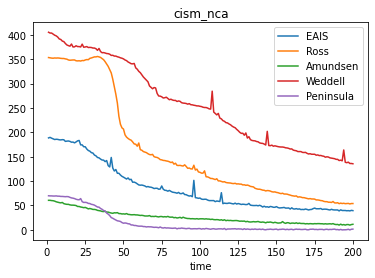

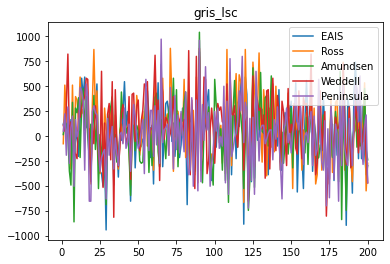

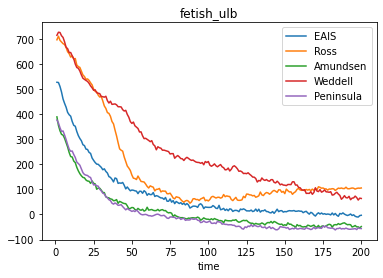

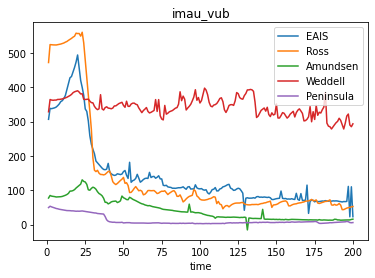

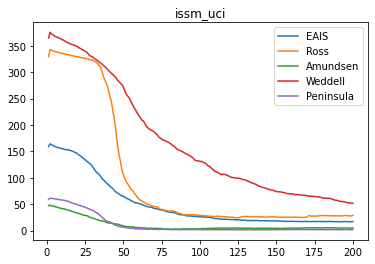

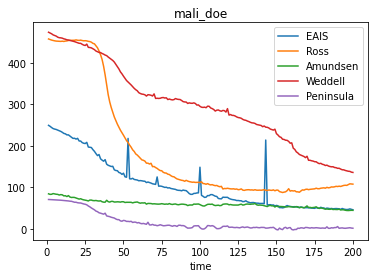

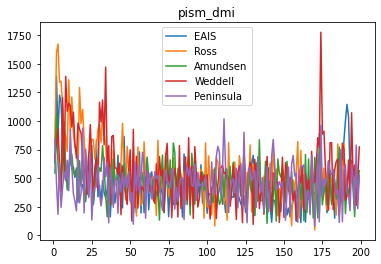

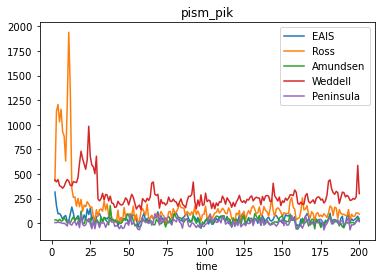

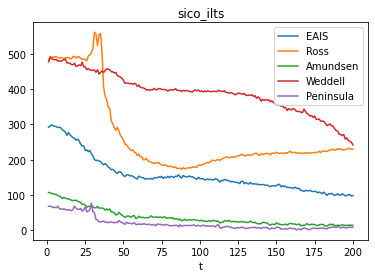

In [20]:
model_list = ['cism_nca', 'gris_lsc', 'fetish_ulb', 'imau_vub', 'issm_uci', 'mali_doe', 'pism_dmi', 'pism_pik', 'sico_ilts']

for model in model_list:
    print(f'Working on {model.upper()}')
    # Read data as csv file and plot
    res = locals()[f'read_{model}']()
    # Compute the LRF
    res = (res.diff()/8)
    
    res.plot()
    plt.title(model)
    # Export as .dat with the same format as Levermann et al. 2020
    for col in range(5):
        res.iloc[1:,col].to_csv(f'{output_dir}RFunctions_total/RF_{model.upper()}_BM08_R{col+1}.dat', index=False, header=False)
        
    plt.savefig(f'{figure_dir}/TotLRF_{model}.pdf',dpi=150)


### Compare the total mass LRF with the sea level LRF for the intersection of models

In [21]:
def read_larmip2_lrf(data_dir, basal_melt):
    '''Read LARMIP2 Linear Response Functions downloaded from:
    https://github.com/ALevermann/Larmip2019.
    Basal melt is in m.y-1. BM02, BM04, BM08, BM16 are available. 
    basal_melt = BM08 is used in Levermann et al. 2020.'''
    
    reg_names = {'R1':'EAIS', 'R2':'Ross', 'R3':'Amundsen', 
                 'R4':'Weddell', 'R5':'Peninsula'}

    for idb, reg in enumerate(reg_names):
        path = f'{data_dir}RF_*_{basal_melt}_{reg}.dat'
        files = glob.glob(path)

        for idf, f in enumerate(files):
            ds = pd.read_csv(f, names=['RF']).to_xarray()
            f2 = f.split('/')[-1]
            ds = ds.expand_dims({'model': [f2[3:-12]]})
            
            if idf ==0:
                ds2 = ds
            else:
                ds2 = xr.concat([ds2, ds], dim='model')

        ds2 = ds2.expand_dims({'region': [reg_names[reg]]})
        if idb == 0:
            RF = ds2
        else:
            RF = xr.concat([RF, ds2], dim='region')

    RF = RF.rename({'index' : 'time'})
    RF = RF.transpose('region', 'model', 'time')
    
    return RF.RF

In [23]:
gmass = read_larmip2_lrf(path_LRF, 'BM08')
# Convert from m sea level to Gt
gmass = gmass*1000*360

totmass = read_larmip2_lrf(path_tot_LRF, 'BM08')

In [24]:
gmass.model

<xarray.DataArray 'model' (model: 17)>
array(['AISM_VUB', 'BISI_LBL', 'BISI_LBL_1KM', 'CISM_NCA', 'FETI_VUB',
       'GRIS_LSC', 'IMAU_VUB', 'ISSM_JPL', 'ISSM_UCI', 'MALI_LAN', 'PISM_AWI',
       'PISM_DMI', 'PISM_PIK', 'PISM_VUW', 'PS3D_PSU', 'SICO_UHO', 'UA_UNN'],
      dtype=object)
Coordinates:
  * model    (model) object 'AISM_VUB' 'BISI_LBL' ... 'SICO_UHO' 'UA_UNN'

In [25]:
totmass.model.data

array(['CISM_NCA', 'FETISH_ULB', 'GRIS_LSC', 'IMAU_VUB', 'ISSM_UCI',
       'MALI_DOE', 'PISM_DMI', 'PISM_PIK', 'SICO_ILTS'], dtype=object)

In [26]:
mod_inter = set(gmass.model.data) & set(totmass.model.data)
mod_inter

{'CISM_NCA', 'GRIS_LSC', 'IMAU_VUB', 'ISSM_UCI', 'PISM_DMI', 'PISM_PIK'}

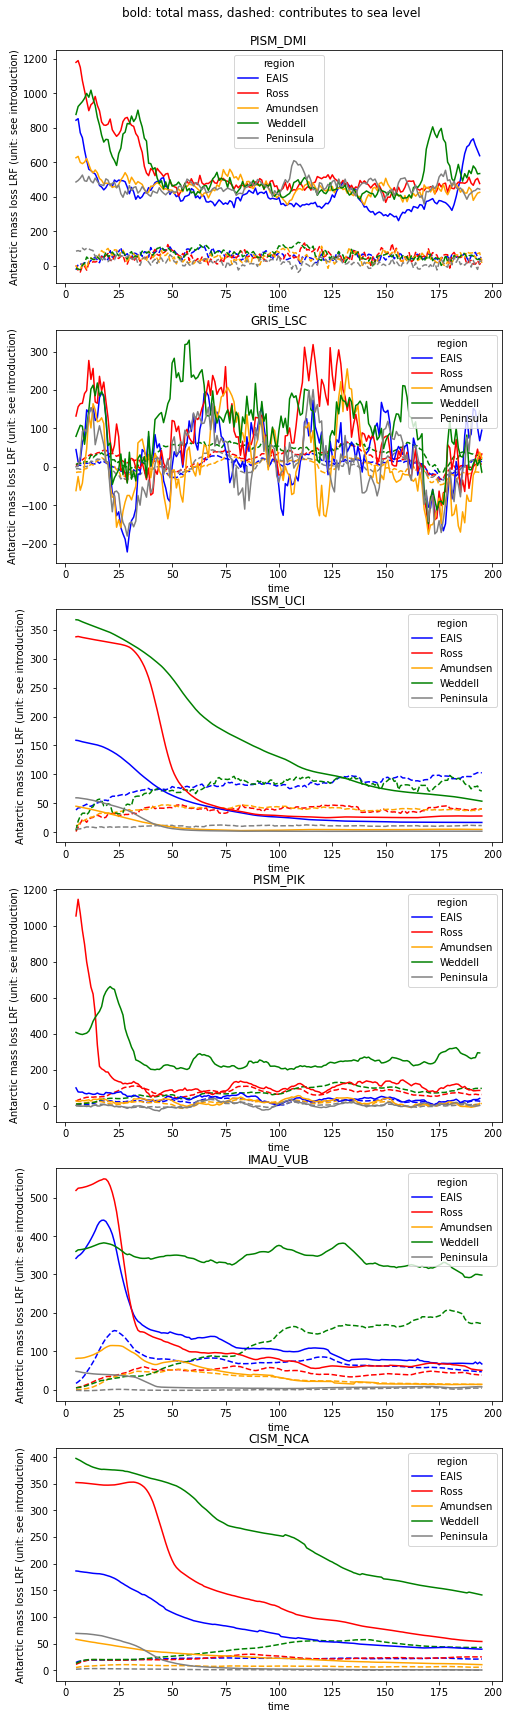

In [28]:
fig, axs = plt.subplots(len(mod_inter), figsize=[8, 5*len(mod_inter)])
plt.suptitle('bold: total mass, dashed: contributes to sea level', y=0.90)

for idx, mod in enumerate(mod_inter):
    axs[idx].set_prop_cycle(color = ['blue', 'red', 'orange', 'green', 'grey'])
    gmass.sel(model=mod).rolling(time=10, center=True).mean().plot.line('--', ax=axs[idx], x='time')
    totmass.sel(model=mod).rolling(time=10, center=True).mean().plot.line(ax=axs[idx], x='time')
    axs[idx].set_ylabel('Antarctic mass loss LRF (unit: see introduction)')
    axs[idx].set_title(f'{mod}')

plt.savefig(f'{figure_dir}CompLRF.pdf', dpi=150)